In [1]:
from ExoRIM.model import RIM, CostFunction
from ExoRIM.simulated_data import CenteredImagesv1
from ExoRIM.utilities import load_dataset
from preprocessing.simulate_data import create_and_save_data
import json
import numpy as np
import os, glob
import collections
import pickle
import time
from datetime import datetime
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
root = os.path.split(os.getcwd())[0]
root

'/lustre04/scratch/aadam/ExoRIM'

In [3]:
#id = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
#id = "20-06-21_10-24-04"
#id = '20-06-22_13-38-14'
id = '20-06-22_18-19-03'
id

'20-06-22_18-19-03'

In [4]:
data_dir = os.path.join(root, "data", id)
if not os.path.isdir(data_dir): os.mkdir(data_dir)
test_dir = os.path.join(root, "data", id + "_test")
if not os.path.isdir(test_dir): os.mkdir(test_dir)
projector_dir = os.path.join(root, "data", "projector_arrays")
checkpoint_dir = os.path.join(root, "models", id)
if not os.path.isdir(checkpoint_dir): os.mkdir(checkpoint_dir)
output_dir = os.path.join(root, "results", id)
if not os.path.isdir(output_dir): os.mkdir(output_dir)

In [43]:
#with open(os.path.join(root, "hyperparameters.json"), "r") as f:
#    hparams = json.load(f)
with open(os.path.join(checkpoint_dir, "hyperparameters.json"), "r") as f:
     hparams = json.load(f)
hparams

{'steps': 12,
 'pixels': 32,
 'channels': 1,
 'state_size': 16,
 'state_depth': 32,
 'Regularizer Amplitude': {'kernel': 0.01, 'bias': 0.01},
 'Physical Model': {'Visibility Noise': 0.0001, 'Closure Phase Noise': 1e-05},
 'Downsampling Block': [{'Conv_Downsample': {'kernel_size': [5, 5],
    'filters': 1,
    'strides': [2, 2]}}],
 'Convolution Block': [{'Conv_1': {'kernel_size': [3, 3],
    'filters': 8,
    'strides': [1, 1]}},
  {'Conv_2': {'kernel_size': [3, 3], 'filters': 16, 'strides': [1, 1]}}],
 'Recurrent Block': {'GRU_1': {'kernel_size': [3, 3], 'filters': 16},
  'Hidden_Conv_1': {'kernel_size': [3, 3], 'filters': 16},
  'GRU_2': {'kernel_size': [3, 3], 'filters': 16}},
 'Upsampling Block': [{'Conv_Fraction_Stride': {'kernel_size': [3, 3],
    'filters': 16,
    'strides': [2, 2]}}],
 'Transposed Convolution Block': [{'TConv_1': {'kernel_size': [3, 3],
    'filters': 8,
    'strides': [1, 1]}},
  {'TConv_2': {'kernel_size': [3, 3], 'filters': 1, 'strides': [1, 1]}}],
 'epoch'

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def create_dataset(meta_data, rim, dirname, batch_size=None):
    images = tf.convert_to_tensor(create_and_save_data(dirname, meta_data), dtype=tf.float32)
    k_images = rim.physical_model.simulate_noisy_image(images)
    X = tf.data.Dataset.from_tensor_slices(k_images)  # split along batch dimension
    Y = tf.data.Dataset.from_tensor_slices(images)
    dataset = tf.data.Dataset.zip((X, Y))
    if batch_size is not None: # for train set
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.enumerate(start=0)
        dataset = dataset.cache()  # accelerate the second and subsequent iterations over the dataset
        dataset = dataset.prefetch(AUTOTUNE)  # Batch is prefetched by CPU while training on the previous batch occurs
    else:
        # batch together all examples, for test set
        dataset = dataset.batch(images.shape[0], drop_remainder=True)
        dataset = dataset.cache()
    return dataset

In [7]:
holes = 20
# metrics only support grey scale images
metrics = {
    "ssim": lambda Y_pred, Y_true: tf.image.ssim(Y_pred, Y_true, max_val=1.0),
    # Bug is tf 2.0.0, make sure filter size is small enough such that H/2**4 and W/2**4 >= filter size
    # alternatively (since H/2**4 is = 1 in our case), it is possible to lower the power factors such that
    # H/(2**(len(power factor)-1)) > filter size
    # Hence, using 3 power factors with filter size=2 works, and so does 2 power factors with filter_size <= 8
    # paper power factors are [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
    # After test, it seems filter_size=11 also works with 2 power factors and 32 pixel image
    "ssim_multiscale_01": lambda Y_pred, Y_true: tf.image.ssim_multiscale(
        Y_pred, Y_true, max_val=1.0,
        filter_size=11,
        power_factors=[0.0448, 0.2856]),
    "ssim_multiscale_23": lambda Y_pred, Y_true: tf.image.ssim_multiscale(
        Y_pred, Y_true, max_val=1.0,
        filter_size=11,
        power_factors=[0.3001, 0.2363]),
    "ssim_multiscale_34": lambda Y_pred, Y_true: tf.image.ssim_multiscale(
        Y_pred, Y_true, max_val=1.0,
        filter_size=11,
        power_factors=[0.2363, 0.1333])
}
cost_function = CostFunction()
mask_coordinates = np.loadtxt(os.path.join(projector_dir, f"mask_{holes}_holes.txt"))
with open(os.path.join(projector_dir, f"projectors_{holes}_holes.pickle"), "rb") as fb:
    arrays = pickle.load(fb)

In [52]:
#weight_file = os.path.join(checkpoint_dir, "rim_005_115.67728.h5")
#weight_file=os.path.join(checkpoint_dir, "rim_035_11.35379.h5")
weight_file=os.path.join(checkpoint_dir, "rim_098_15.75180.h5")
#weight_file=None
rim = RIM(mask_coordinates=mask_coordinates, hyperparameters=hparams, arrays=arrays, weight_file=weight_file)

In [9]:
meta_data = CenteredImagesv1(total_items=1000, pixels=32)
test_meta = CenteredImagesv1(total_items=200, pixels=32)
train_dataset = create_dataset(meta_data, rim, data_dir, batch_size=50)
test_dataset = create_dataset(test_meta, rim, test_dir)
# train_dataset = load_dataset(data_dir, rim, batch_size=50)
# test_dataset = load_dataset(test_dir, rim)

In [ ]:
if os.path.isfile(os.path.join(output_dir, "history.pickle")):
    with open(os.path.join(output_dir, "history.pickle"), "rb") as f:
        history = pickle.load(f)
else:
    history = {key + "_train": [] for key in metrics.keys()}
    history.update({key + "_test": [] for key in metrics.keys()})
    history.update({"train_loss": [], "test_loss": []})
start = time.time()
_history = rim.fit(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    max_time=0.8,
    cost_function=cost_function,
    min_delta=0,
    patience=10,
    checkpoints=5,
    output_dir=output_dir,
    checkpoint_dir=checkpoint_dir,
    max_epochs=70,
    output_save_mod={"index_mod": 300,
                     "epoch_mod": 1,
                     "step_mod": 11}, # save first and last step imagees
    metrics=metrics,
    name="rim"
)
end = time.time() - start
print(f"Training took {end/60:.02f} minute")

In [46]:
with open(os.path.join(checkpoint_dir, "hyperparameters.json"), "w") as f:
    json.dump(rim.hyperparameters, f)

In [47]:
for key, item in _history.items():
    history[key].extend(item)
with open(os.path.join(output_dir, "history.pickle"), "wb") as f:
    pickle.dump(history, f)

In [48]:
history["train_loss"]

[241.94124,
 66.19267,
 56.345245,
 50.3719,
 43.513863,
 35.895218,
 30.85555,
 26.696148,
 24.472286,
 23.526653,
 25.622732,
 26.788975,
 34.040634,
 26.358143,
 20.142132,
 19.406338,
 19.170404,
 18.78827,
 18.754877,
 18.968184,
 18.863161,
 17.786917,
 18.168411,
 17.54705,
 17.412416,
 15.580187,
 14.701436,
 14.628352,
 14.582952,
 14.533079,
 14.490044,
 14.447741,
 14.422986,
 14.398577,
 14.379988,
 14.361885,
 14.344313,
 14.327212,
 14.310658,
 14.294207,
 14.278051,
 14.262331,
 14.246286,
 14.23041,
 14.237822,
 14.221161,
 14.211992,
 14.207639,
 14.205335,
 14.20413,
 14.2034855,
 14.203125,
 14.202986,
 14.202909,
 14.202782,
 14.203821,
 14.20161,
 14.200177,
 14.19601,
 14.193921,
 14.191501,
 14.189627,
 14.1874695,
 14.186078,
 14.185557,
 14.181895,
 14.180384,
 14.178482,
 14.177869,
 14.174948,
 14.173492,
 14.1715145,
 14.170883,
 14.167931,
 14.166494,
 14.16448,
 14.163828,
 14.160937,
 14.159624,
 14.157476,
 14.156794,
 14.154019,
 14.152908,
 14.150556,


In [49]:
# update of nested dictionaries
def update(d, u):
    for k, v in u.items():
        if isinstance(v, collections.abc.Mapping):
            d[k] = update(d.get(k, {}), v)
        else:
            d[k] = v
    return d

images = {}
for file in glob.glob(os.path.join(output_dir, "output*")):
    name = os.path.split(file)[-1]
    epoch = int(name[7:10])
    index = int(name[11:15])
    step = int(name[16:18])
    with Image.open(file) as image:
        im = np.array(image.getdata()).reshape([image.size[0], image.size[1]])
        update(images, {index: {epoch : {step: im}}})

In [26]:
index=900
images.keys()

dict_keys([900, 300, 600, 0])

In [50]:
epoch = max(images[0].keys())
print(epoch)
images[0].keys()

98


dict_keys([49, 74, 24, 16, 92, 19, 34, 9, 82, 6, 56, 59, 64, 29, 14, 90, 44, 79, 76, 54, 66, 69, 39, 36, 80, 4, 10, 94, 22, 72, 40, 62, 50, 84, 32, 70, 42, 12, 96, 20, 86, 2, 89, 30, 60, 52, 61, 53, 88, 87, 3, 31, 13, 97, 98, 21, 71, 43, 85, 1, 33, 63, 51, 73, 41, 11, 95, 23, 37, 38, 81, 5, 55, 68, 67, 45, 77, 78, 28, 27, 15, 91, 57, 65, 35, 83, 7, 8, 25, 18, 17, 93, 47, 48, 75])

In [28]:
step=max(images[index][epoch])
images[index][epoch].keys()

dict_keys([0, 11])

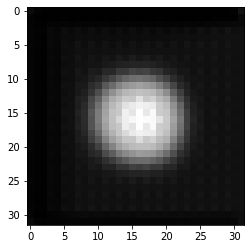

In [51]:
plt.imshow(images[index][epoch][step], cmap="gray")

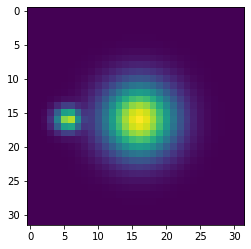

In [31]:
gt_file = os.path.join(data_dir, "image" + str(index) + ".png")
with Image.open(gt_file) as image:
    im = np.array(image.getdata()).reshape([32,32])
plt.imshow(im)